In [ ]:
!pip install qiskit

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit import Aer, execute
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as tf_mnist
from skimage.transform import resize

In [ ]:
# Functions for amplitude encoding and decoding
class Encoder:
    def __init__(self, size=256):
        self.dataset = []
        self.norm_list = [] # = np.linalg.norm(dataset)
        self.size = size


    def encode_list(self, dataset):
        output = []
        for item in dataset:
            encoded = self.encode(item)
            output.append(encoded)

        return output

    def encode(self, dataset):

        if len(dataset.shape) > 2:
            return self.encode_list(dataset)

        # Calculate the number of qubits needed to encode the values
        num_qubits = int(np.ceil(np.log2(len(self.dataset))))
        qc = QuantumCircuit(num_qubits)

        # Initialize the quantum circuit to the desired state
        norm = np.linalg.norm(dataset)
        desired_state = dataset / norm
        desired_state = np.pad(desired_state, (0, 2 ** num_qubits - len(desired_state)), mode='constant', constant_values=0)
        qc.initialize(desired_state, list(range(num_qubits)))

        # Return the quantum circuit

        self.dataset.append(qc)
        self.norm_list.append(norm)

        return qc

    def decode_all(self, shots=1000000):
        output = []

        for i in range(len(self.dataset)):
            decoded = self.decode(i, shots=shots)
            output.append(decoded)

        return output

    def decode(self, i, shots=1000000):
        qc = self.dataset[i]
        norm = self.norm_list[i]

        # Measure the quantum circuit
        qc.measure_all()
        simulator = Aer.get_backend('qasm_simulator')
        job = execute(qc, simulator, shots=shots)
        result = job.result()
        counts = result.get_counts()

        # Use the counts to estimate the values
        decoded = np.zeros(self.size)
        for i, j in counts.items():
            decoded[int(i, 2)] = round((j / shots) ** 0.5 * norm)

        return decoded

In [ ]:
class dataset:
    def __init__(self):
        (_, _), (data, labels) = tf_mnist.mnist.load_data()

        self.og_data = data

        new_data = np.zeros((data.shape[0], 16, 16))
        for i, image in enumerate(data):
            resized_image = resize(image.reshape(28, 28), (16, 16))
            new_data[i] = resized_image

        self.downsized_data = new_data
        self.data = new_data.reshape(data.shape[0], -1)
        self.labels = labels

    def display_image(self, index):
        # Get the image and label at the specified index
        image = self.downsized_data[index]
        label = self.labels[index]

        # Display the image
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

    def get_data(self, i):
        return self.data[i], self.labels[i]

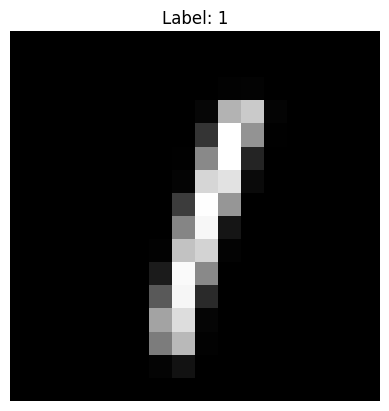

In [ ]:
my_dataset = dataset()
my_dataset.display_image(5)
image, label = my_dataset.get_data(5)

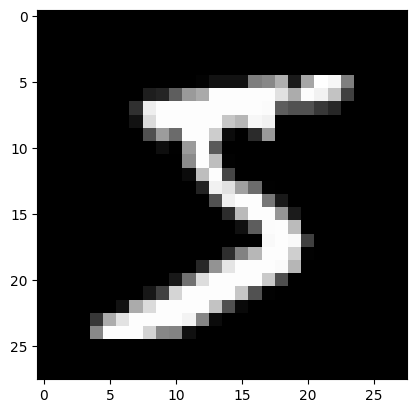

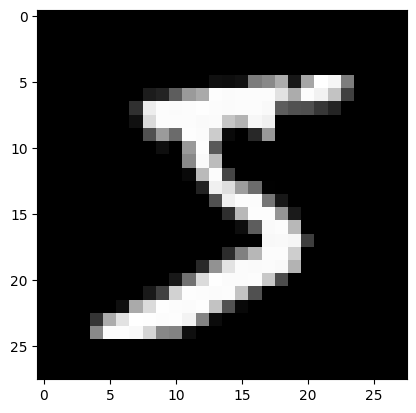

In [ ]:
# Test of amplitude encoding and decoding functions on MNIST data

# Use one image from the MNIST dataset as a test input
train_images = images #read_images('MNIST/raw/train-images-idx3-ubyte')
dataset = train_images[0]
dataset = np.reshape(dataset, -1)
#dataset = [1, 3, 4, 2]

encoder = Encoder(dataset)

# Encode the dataset
qc = encoder.encode(dataset)

# Plot the qubit states
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

# Display the original and encoded/decoded values as images
plt.figure("Original Dataset")
plt.imshow(dataset.reshape(28, 28), cmap='gray')
plt.figure("Decoded Dataset")
plt.imshow(encoder.decode(qc).reshape(28, 28), cmap='gray')
plt.show()

To do

In [ ]:
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def conv_circuit(kernel_size, params):
    target = QuantumCircuit(kernel_size+1)

    for i in range(kernel_size):
        target.rz(-np.pi / 2, i+1)
        target.crx(params[i*3], i+1, 0)
        target.cry(params[i*3+1], i+1, 0)
        target.crz(params[i*3+2], i+1, 0)
    target.rz(np.pi / 2, 0)
    return target


def conv_layer(kernel_size, info_qs, param_prefix):
    conv_size = info_qs - kernel_size + 1
    num_qubits = conv_size + info_qs

    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))

    param_index = 0
    params = ParameterVector(param_prefix, length=conv_size * kernel_size * 3)

    for i in range(conv_size):
        qc = qc.compose(other=conv_circuit(kernel_size, params[param_index : (param_index + 3 * kernel_size)]), qubits=[qubits[-(i+1)]].extend(qubits[i:i+kernel_size]))
        qc.barrier()
        param_index += 3 * kernel_size
        print(param_index)

    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import numpy as np

# Step 1: Define the classical CNN architecture
class ClassicalCNN(nn.Module):
    def __init__(self):
        super(ClassicalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 2: Convert the classical CNN into a QCNN
def quantum_convolution_layer(qc, input_qubits, output_qubits, filter_size):
    # Apply controlled gates for the convolution operation
    for i, input_qubit in enumerate(input_qubits):
        for j, output_qubit in enumerate(output_qubits):
            # Define a parameterized rotation gate
            theta = Parameter(f'theta_{i}_{j}')
            qc.rz(theta, output_qubit)
            qc.cx(input_qubit, output_qubit)

    # Apply pooling operation (e.g., quantum amplitude amplification)
    for output_qubit in output_qubits:
        qc.h(output_qubit)
        qc.x(output_qubit)
    qc.mcx(output_qubits[:-1], output_qubits[-1])
    for output_qubit in output_qubits:
        qc.x(output_qubit)
        qc.h(output_qubit)

# Step 3: Define the QCNN model using Qiskit
class QCNN():
    def __init__(self, classical_model):
        self.classical_model = classical_model
        self.qcnn_model = QuantumCircuit()
        self.input_qubits = QuantumRegister(2, 'input')
        self.output_qubits = QuantumRegister(2, 'output')
        self.aux_qubits = QuantumRegister(1, 'aux')
        self.c = ClassicalRegister(2, 'c')
        self.qcnn_model.add_register(self.input_qubits, self.output_qubits, self.aux_qubits, self.c)
        self.build()

    def build(self):
        # Initialize input qubits
        self.qcnn_model.rx(0.785, self.input_qubits[0])
        self.qcnn_model.rx(0.785, self.input_qubits[1])

        # Apply quantum convolution layer
        quantum_convolution_layer(self.qcnn_model, self.input_qubits, self.output_qubits, filter_size=3)

        # Measure output qubits
        self.qcnn_model.measure(self.output_qubits, self.c)

    def forward(self, x):
        backend = qiskit.Aer.get_backend('qasm_simulator')
        job = qiskit.execute(self.qcnn_model, backend, shots=1)
        result = job.result().get_counts()
        return result

# Step 4: Train the QCNN
def train_qcnn(qcnn_model, trainloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(qcnn_model.classical_model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            outputs = qcnn_model.forward(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print("Training Complete")

# Step 5: Evaluate the QCNN
def evaluate_qcnn(qcnn_model, testloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = qcnn_model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %.2f %%' % (100 * correct / total))

# Step 6: Main program
if __name__ == '__main__':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)

    classical_model = ClassicalCNN()
    qcnn_model = QCNN(classical_model)
    train_qcnn(qcnn_model, trainloader)
    evaluate_qcnn(qcnn_model, testloader)